In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution,
                       fiber_segments_phantom, evaluate_directions,
                       evaluate_metric, pca_noise_classifier)

In [2]:
def pca_denoising(dwi, ps=2, overcomplete=False):
    """ Denoises DWI volumes using PCA analysis and Marchenko–Pastur
    probability theory

    Parameters
    ----------
    dwi : array ([X, Y, Z, g])
        Matrix containing the 4D DWI data.
    ps : int
        Number of neighbour voxels for the PCA analysis.
        Default: 2
    overcomplete : boolean
        If set to True, overcomplete local PCA is computed
        Default: False

    Returns
    -------
    den : array ([X, Y, Z, g])
        Matrix containing the denoised 4D DWI data.
    std : array ([X, Y, Z])
        Matrix containing the noise std estimated using
        Marchenko-Pastur probability theory.
    ncomps : array ([X, Y, Z])
        Number of eigenvalues preserved for the denoised
        4D data.
    """
    # Compute dimension of neighbour sliding window
    m = (2*ps + 1) ** 3

    n = dwi.shape[3]
    den = np.zeros(dwi.shape)
    ncomps = np.zeros(dwi.shape[:3])
    sig2 = np.zeros(dwi.shape[:3])
    if overcomplete:
        wei = np.zeros(dwi.shape)

    for k in range(ps, dwi.shape[2] - ps):
        for j in range(ps, dwi.shape[1] - ps):
            for i in range(ps, dwi.shape[0] - ps):
                # Compute eigenvalues for sliding window
                X = dwi[i - ps: i + ps + 1, j - ps: j + ps + 1,
                        k - ps: k + ps + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)

                # Find number of noise related eigenvalues
                c, sig = pca_noise_classifier(L, m)
                ncomps[i, j, k] = n - c
                sig2[i, j, k] = sig

                # Reconstruct signal without noise components
                Y = X.dot(W[:, c:])
                X = Y.dot(W[:, c:].T)
                X = X + M
                X = X.reshape(2*ps + 1, 2*ps + 1, 2*ps + 1, n)

                # Overcomplete weighting
                if overcomplete:
                    w = 1.0 / (1.0 + n - c)
                    wei[i - ps: i + ps + 1,
                        j - ps: j + ps + 1,
                        k - ps: k + ps + 1] = wei[i - ps: i + ps + 1,
                                                  j - ps: j + ps + 1,
                                                  k - ps: k + ps + 1] + w
                    X = X * w
                    den[i - ps: i + ps + 1,
                        j - ps: j + ps + 1,
                        k - ps: k + ps + 1, :] = den[i - ps: i + ps + 1,
                                                     j - ps: j + ps + 1,
                                                     k - ps: k + ps + 1, :] + X
                else:
                    den[i, j, k, :] = X[ps, ps, ps]

    if overcomplete:
        den = den / wei
    return den, np.sqrt(sig2), ncomps

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

acquisition = 0

if acquisition == 0:

    # Sample 8 diffusion-weighted directions for first shell
    n_pts = 8
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 5000)
    directions8 = hsph_updated.vertices  # directions for each shell

    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Sample 60 diffusion-weighted directions for second shell
    n_pts = 60
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions60 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                       1000 * np.ones(30), 2000 * np.ones(60)))
    bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
    gtab = gradient_table(bvals, bvecs)
    
else:
    # Sample 30 diffusion-weighted directions for second shell
    n_pts = 30
    theta = np.pi * np.random.rand(n_pts)
    phi = 2 * np.pi * np.random.rand(n_pts)
    hsph_initial = HemiSphere(theta=theta, phi=phi)
    hsph_updated, potential = disperse_charges(hsph_initial, 50000)
    directions30 = hsph_updated.vertices  # directions for each shell

    # Create full dataset parameters
    bvals = np.hstack((np.zeros(6), 1000 * np.ones(30), 2000 * np.ones(30)))
    bvecs = np.vstack((np.zeros((6, 3)), directions30, directions30))
    gtab = gradient_table(bvals, bvecs)

In [4]:
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [5]:
p = 2
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])

snr = 15
sigma = 50.0 /snr

Phantom = fiber_segments_phantom(gtab, fsigmas[p])

matsiz = Phantom.shape
nrep=10
matsiz = matsiz + (nrep,)
Phantom_all = np.zeros(matsiz)
Pden_all = np.zeros(matsiz)
Pden_over = np.zeros(matsiz)

n1 = np.random.normal(0, sigma, size=Phantom.shape)
n2 = np.random.normal(0, sigma, size=Phantom.shape)
Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
Phantom_all[..., 0] = Phantom_gt

[Pden1, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2)
Pden_all[..., 0] = Pden1
[Pden2, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2, overcomplete=True)
Pden_over[..., 0] = Pden2

for rep in range(1, nrep):
    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Noise = _add_rician(Phantom.copy(), n1, n2)
    Phantom_all[..., rep] = Noise
    Phantom_gt = Phantom_gt + Noise
    [Pden1, sig, ncomps] = pca_denoising(Noise.copy(), ps=2)
    Pden_all[..., rep] = Pden1
    [Pden2, sig, ncomps] = pca_denoising(Noise.copy(), ps=2, overcomplete=True)
    Pden_over[..., rep] = Pden2
Phantom_gt = Phantom_gt / nrep

In [6]:
Pen_std = np.mean(np.mean(np.mean(np.std(Pden_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Pen_std.shape

(104L,)


In [7]:
Over_std = np.mean(np.mean(np.mean(np.std(Pden_over[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Over_std.shape

(104L,)


In [8]:
Raw_std = np.mean(np.mean(np.mean(np.std(Phantom_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
print Raw_std.shape

(104L,)


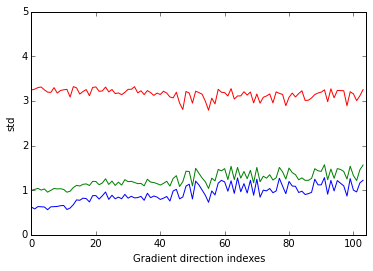

In [9]:
plt.plot(range(Raw_std.size), Raw_std, 'r')
plt.plot(range(Raw_std.size), Pen_std, 'g')
plt.plot(range(Raw_std.size), Over_std, 'b')
plt.axis([0, Raw_std.size, 0, 5])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

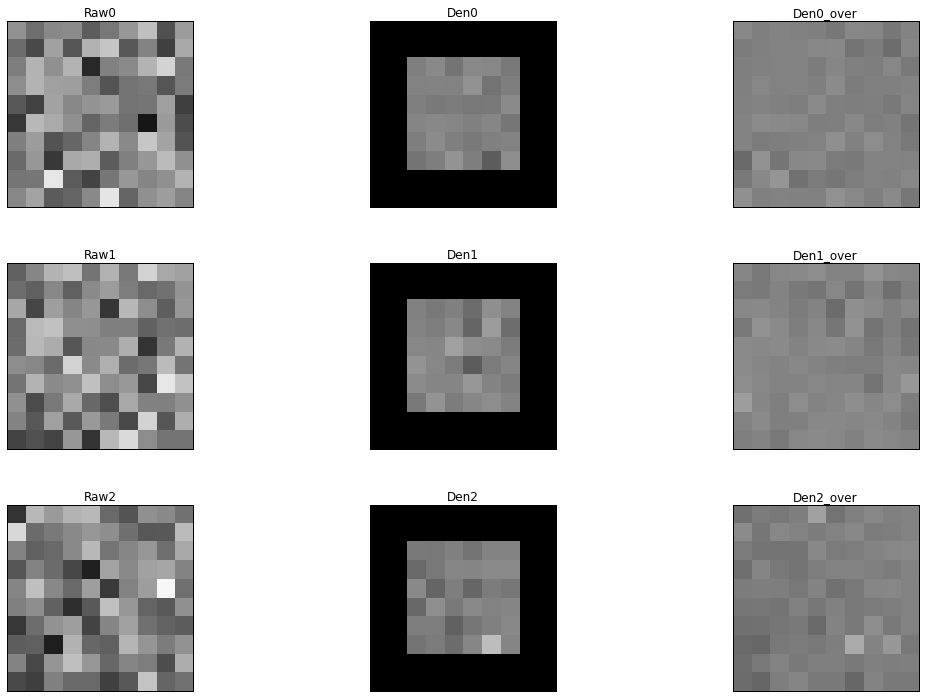

In [10]:
fig2, ax = plt.subplots(3, 3, figsize=(18, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.3)

vol = 0

ax.flat[0].imshow(Phantom_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[0].set_title('Raw0')
ax.flat[1].imshow(Pden_all[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[1].set_title('Den0')
ax.flat[2].imshow(Pden_over[:, :, 3, vol, 0], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[2].set_title('Den0_over')
ax.flat[3].imshow(Phantom_all[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[3].set_title('Raw1')
ax.flat[4].imshow(Pden_all[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[4].set_title('Den1')
ax.flat[5].imshow(Pden_over[:, :, 3, vol, 1], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[5].set_title('Den1_over')
ax.flat[6].imshow(Phantom_all[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[6].set_title('Raw2')
ax.flat[7].imshow(Pden_all[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[7].set_title('Den2')
ax.flat[8].imshow(Pden_over[:, :, 3, vol, 2], cmap='gray', interpolation="nearest", clim=(40, 60))
ax.flat[8].set_title('Den2_over')
plt.show()

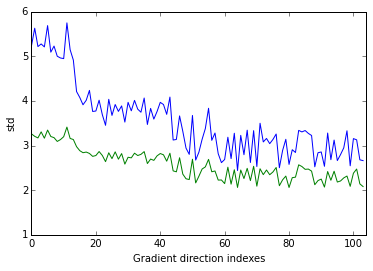

In [11]:
Ganho = Raw_std/Pen_std
Ganho2 = Raw_std/Over_std
plt.plot(range(Raw_std.size), Ganho, 'g')
plt.plot(range(Raw_std.size), Ganho2, 'b')
plt.axis([0, Raw_std.size, 1, 6])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

Figures show that there is a gain dependence with b-value. Moreover, we can observe that the gain for a single b-value is not uniform but also depends in the gradient value. Above I will check if this gain is related to the signal intensity

In [12]:
Pen_std2000 = np.std(Pden_all[2:-2, 2:-2, 2:-2, bvals==2000, :], axis=4, ddof=1)
Over_std2000 = np.std(Pden_over[2:-2, 2:-2, 2:-2, bvals==2000, :], axis=4, ddof=1)
Raw_std2000 = np.std(Phantom_all[2:-2, 2:-2, 2:-2, bvals==2000, :], axis=4, ddof=1)

Pen_std1000 = np.std(Pden_all[2:-2, 2:-2, 2:-2, bvals==1000, :], axis=4, ddof=1)
Over_std1000 = np.std(Pden_over[2:-2, 2:-2, 2:-2, bvals==1000, :], axis=4, ddof=1)
Raw_std1000 = np.std(Phantom_all[2:-2, 2:-2, 2:-2, bvals==1000, :], axis=4, ddof=1)

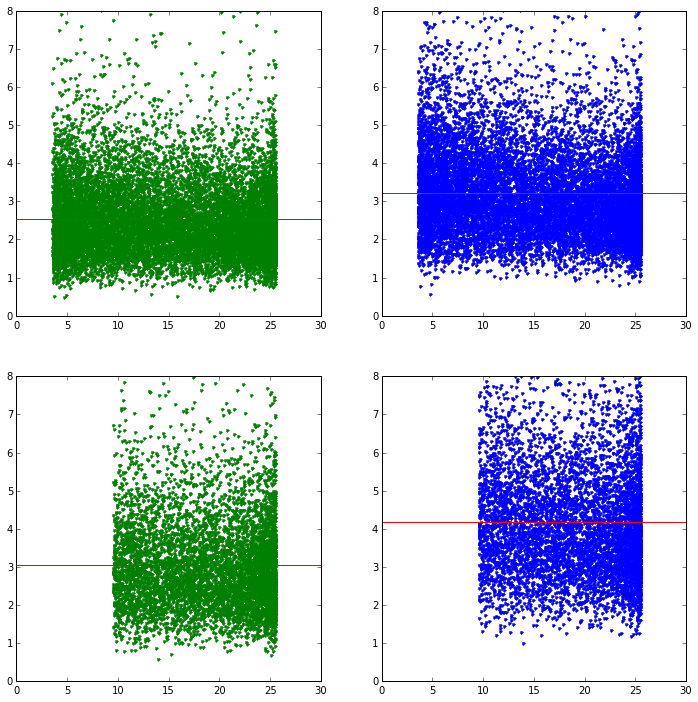

In [13]:
Gain1000 = Raw_std1000/Pen_std1000
Gain_over1000 = Raw_std1000/Over_std1000
Gain1000 = Gain1000.ravel()
Gain_over1000 = Gain_over1000.ravel()

Gain2000 = Raw_std2000/Pen_std2000
Gain_over2000 = Raw_std2000/Over_std2000
Gain2000 = Gain2000.ravel()
Gain_over2000 = Gain_over2000.ravel()

Phant2000 = Phantom[2:-2, 2:-2, 2:-2, bvals==2000].ravel()
Phant1000 = Phantom[2:-2, 2:-2, 2:-2, bvals==1000].ravel()

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].plot(Phant2000, Gain2000, '.g')
ax[0, 0].plot(np.array([0., 30.]), np.mean(Gain2000)*np.ones(2), 'r')
ax[0, 0].set_ylim([0, 8])
ax[0, 1].plot(Phant2000, Gain_over2000, '.b')
ax[0, 1].plot(np.array([0., 30.]), np.mean(Gain_over2000)*np.ones(2), 'r')
ax[0, 1].set_ylim([0, 8])
ax[1, 0].plot(Phant1000, Gain1000, '.g')
ax[1, 0].plot(np.array([0., 30.]), np.mean(Gain1000)*np.ones(2), 'r')
ax[1, 0].set_ylim([0, 8])
ax[1, 1].plot(Phant1000, Gain_over1000, '.b')
ax[1, 1].plot(np.array([0., 30.]), np.mean(Gain_over1000)*np.ones(2), 'r')
ax[1, 1].set_ylim([0, 8])
plt.show()

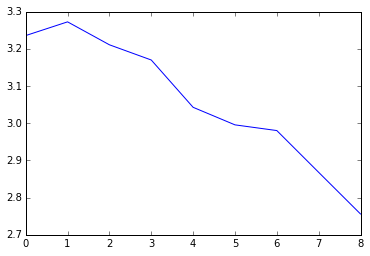

In [14]:
bars = np.array([[2.5, 5], [5, 7.5], [7.5, 10], [10, 12.5],
                 [12.5, 15], [15, 17.5], [17.5, 20], [20, 22.5], [22.5, 25]])
gain_vs_intensity = np.zeros(9)
for i in range(9):
    gain_vs_intensity[i] = np.median(Gain_over2000[np.logical_and(Phant2000>bars[i][0], Phant2000<bars[i][1])])
plt.plot(gain_vs_intensity)
plt.show()

Depends on signal however big statistical variance

Lets run now the full gain analysis several times and compute a average

In [15]:
full_rep = 100

for fr in range(full_rep - 1):
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    Phantom_all = np.zeros(matsiz)
    Pden_all = np.zeros(matsiz)
    Pden_over = np.zeros(matsiz)

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)
    Phantom_all[..., 0] = Phantom_gt

    [Pden1, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2)
    Pden_all[..., 0] = Pden1
    [Pden2, sig, ncomps] = pca_denoising(Phantom_gt.copy(), ps=2, overcomplete=True)
    Pden_over[..., 0] = Pden2

    for rep in range(1, nrep):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Noise = _add_rician(Phantom.copy(), n1, n2)
        Phantom_all[..., rep] = Noise
        Phantom_gt = Phantom_gt + Noise
        [Pden1, sig, ncomps] = pca_denoising(Noise.copy(), ps=2)
        Pden_all[..., rep] = Pden1
        [Pden2, sig, ncomps] = pca_denoising(Noise.copy(), ps=2, overcomplete=True)
        Pden_over[..., rep] = Pden2
    Phantom_gt = Phantom_gt / nrep
    
    Pen_std = np.mean(np.mean(np.mean(np.std(Pden_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
    Over_std = np.mean(np.mean(np.mean(np.std(Pden_over[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
    Raw_std = np.mean(np.mean(np.mean(np.std(Phantom_all[2:-2, 2:-2, 2:-2, :, :], axis=4, ddof=1), axis=0), axis=0), axis=0)
    
    Ganho = Ganho + Raw_std/Pen_std
    Ganho2 = Ganho2 + Raw_std/Over_std
    print fr
Ganho = Ganho / full_rep
Ganho2 = Ganho2 / full_rep

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


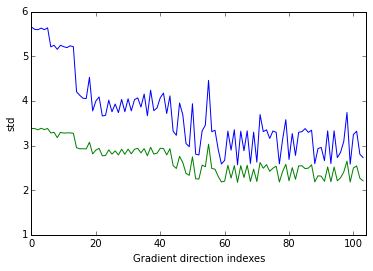

In [16]:
plt.plot(range(Raw_std.size), Ganho, 'g')
plt.plot(range(Raw_std.size), Ganho2, 'b')
plt.axis([0, Raw_std.size, 1, 6])
plt.xlabel('Gradient direction indexes')
plt.ylabel('std')
plt.show()

In [17]:
mean_signal = np.mean(np.mean(np.mean(Phantom[2:-2, 2:-2, 2:-2, :], axis=0), axis=0), axis=0)

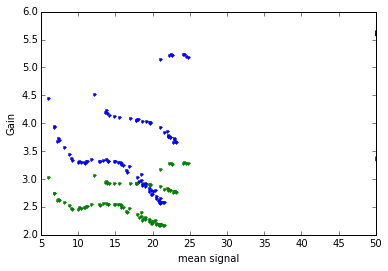

In [18]:
plt.plot(mean_signal, Ganho, '.g')
plt.plot(mean_signal, Ganho2, '.b')
plt.xlabel('mean signal')
plt.ylabel('Gain')
plt.show()